In [81]:
"""
torch LSTM 预测 特斯拉 股票

date [TSLA.csv] from
    https://finance.yahoo.com/quote/TSLA/history
    https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=1517443200&period2=1675245633&interval=1d&events=history&includeAdjustedClose=true
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch import nn

In [82]:
df = pd.read_csv("./TSLA.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-01,23.400000,23.977333,23.242001,23.283333,23.283333,62965500.0
1,2018-02-02,23.229334,23.463333,22.700666,22.916668,22.916668,55572000.0
2,2018-02-05,22.531334,22.964666,22.200001,22.208668,22.208668,66961500.0
3,2018-02-06,21.680668,22.414667,21.566668,22.264668,22.264668,76326000.0
4,2018-02-07,22.599333,23.066668,22.377333,23.000000,23.000000,104538000.0
...,...,...,...,...,...,...,...
1253,2023-01-25,141.910004,146.410004,138.070007,144.429993,144.429993,192734300.0
1254,2023-01-26,159.970001,161.419998,154.759995,160.270004,160.270004,234815100.0
1255,2023-01-27,162.429993,180.679993,161.169998,177.899994,177.899994,305632100.0
1256,2023-01-30,178.050003,179.770004,166.500000,166.660004,166.660004,230878800.0


In [83]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,133.723498,136.831237,130.288272,133.614927,133.614927,1.341028e+08
std,117.277183,119.927006,114.249598,117.090092,117.090092,9.044132e+07
min,12.073333,12.445333,11.799333,11.931333,11.931333,2.940180e+07
25%,21.076668,21.496000,20.644667,21.081333,21.081333,7.615350e+07
50%,100.896667,103.333336,98.073997,100.871330,100.871330,1.034727e+08
75%,235.666672,239.996674,231.369995,236.163330,236.163330,1.598835e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1257 non-null   float64
 2   High       1257 non-null   float64
 3   Low        1257 non-null   float64
 4   Close      1257 non-null   float64
 5   Adj Close  1257 non-null   float64
 6   Volume     1257 non-null   float64
dtypes: float64(6), object(1)
memory usage: 68.9+ KB


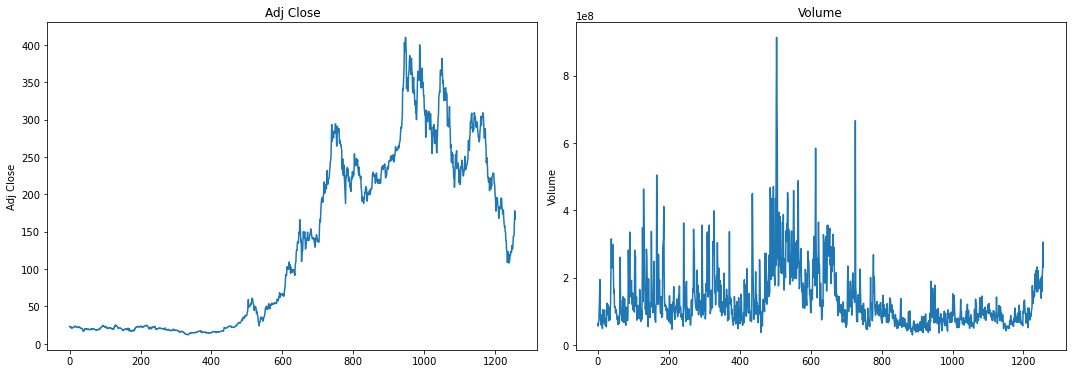

In [85]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

plt.subplot(2, 2, 1)
df['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title("Adj Close")

plt.subplot(2, 2, 2)
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Volume")

plt.tight_layout()

In [86]:
# import seaborn as sns
# sns.pairplot(df, kind='reg')

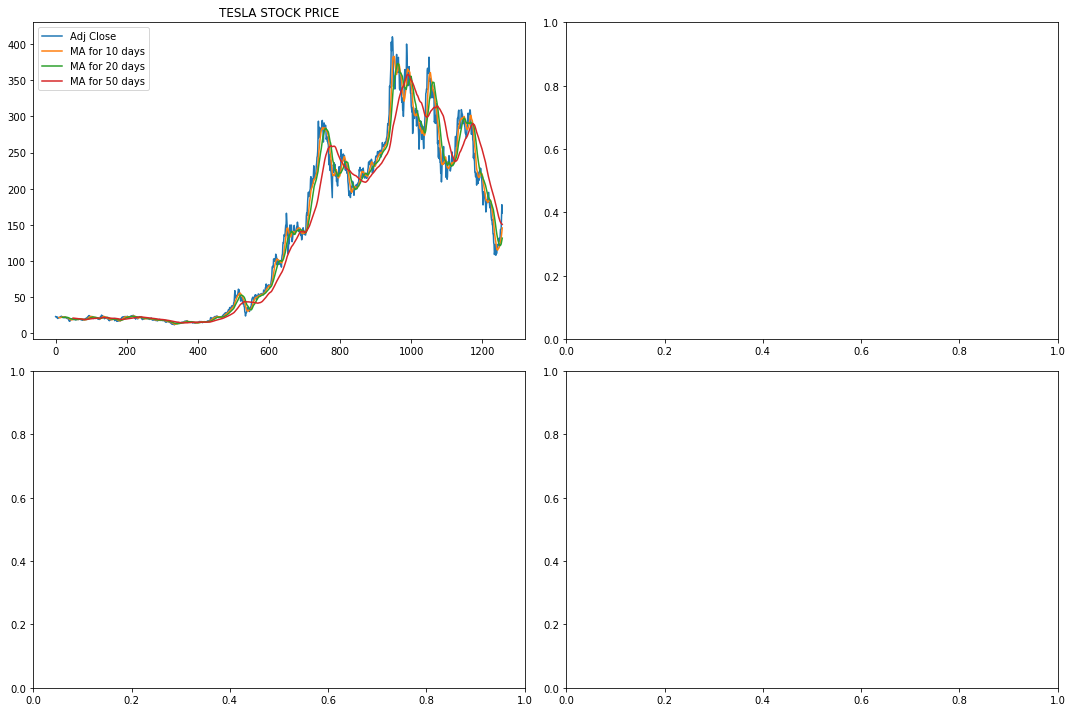

In [87]:
ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Adj Close'].rolling(ma).mean()

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

df[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0, 0])
axes[0, 0].set_title('TESLA STOCK PRICE')
fig.tight_layout()

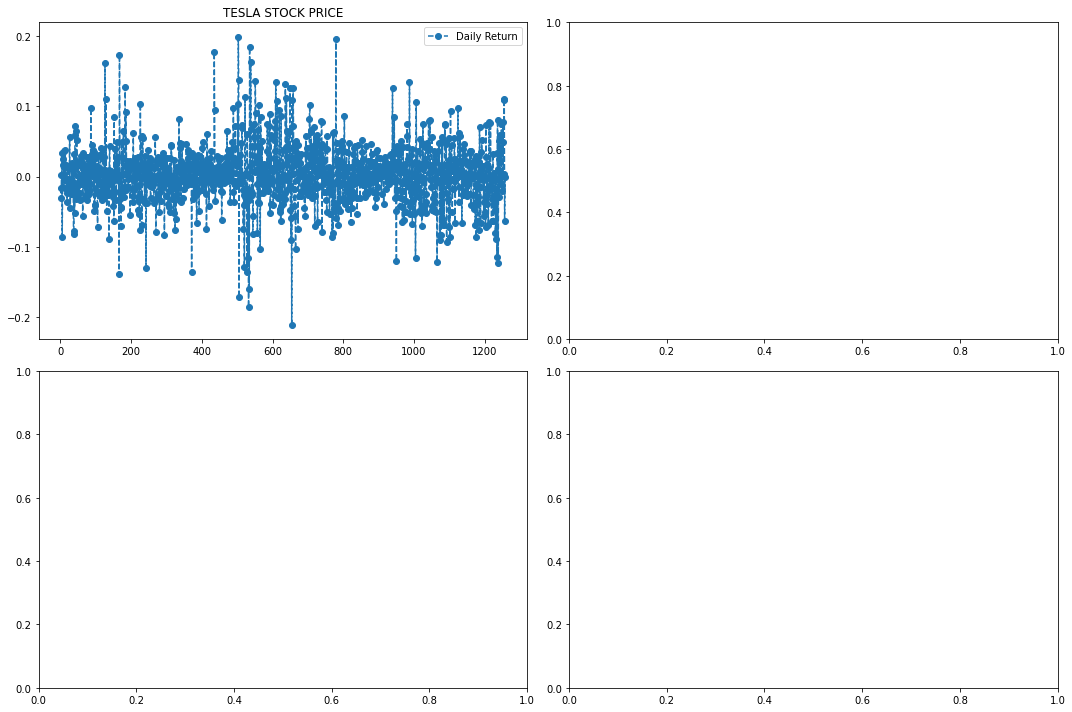

In [88]:
# 收益图
df['Daily Return'] = df['Adj Close'].pct_change()

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

df['Daily Return'].plot(ax=axes[0, 0], legend=True, linestyle='--', marker='o')
axes[0, 0].set_title('TESLA STOCK PRICE')
fig.tight_layout()

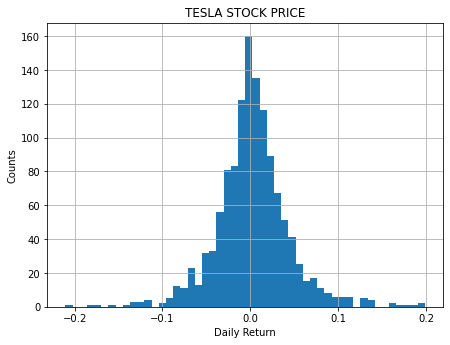

In [89]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
df['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title("TESLA STOCK PRICE")

plt.tight_layout()

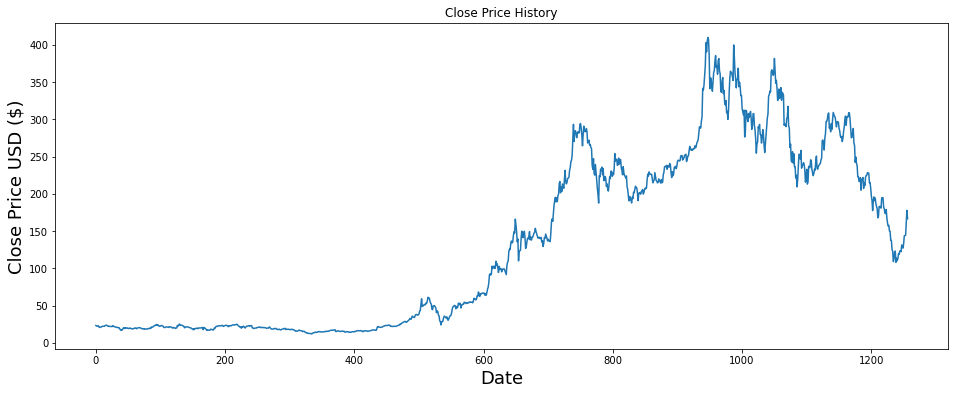

In [90]:
plt.figure(figsize=(16, 6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [91]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

training_data_len

1196

In [92]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02851984],
       [0.02759866],
       [0.02581994],
       ...,
       [0.41696618],
       [0.38872774],
       [       nan]])

In [93]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.02851984, 0.02759866, 0.02581994, 0.02596063, 0.02780802,
       0.0228219 , 0.02201629, 0.02290565, 0.02423383, 0.02400772,
       0.02597738, 0.02621521, 0.02609462, 0.02584841, 0.02800398,
       0.02898881, 0.02988822, 0.02881127, 0.02748309, 0.02545146,
       0.02615324, 0.02585678, 0.02499422, 0.02568092, 0.02514496,
       0.02482171, 0.02789344, 0.02727876, 0.02473127, 0.02455875,
       0.02384693, 0.0225422 , 0.02203806, 0.02303964, 0.0217952 ,
       0.020529  , 0.02097116, 0.01678396, 0.01319972, 0.01459825,
       0.01231204, 0.01483273, 0.01808367, 0.02122909, 0.02015382,
       0.01853924, 0.02105826, 0.02042683, 0.01927953, 0.02032801,
       0.01879884, 0.01820929, 0.01915727, 0.02028446, 0.01863638,
       0.01748574, 0.01750081, 0.01703687, 0.01783914, 0.01927953])]
[0.019249383579989263]

[array([0.02851984, 0.02759866, 0.02581994, 0.02596063, 0.02780802,
       0.0228219 , 0.02201629, 0.02290565, 0.02423383, 0.02400772,
       0.02597738, 0.02621521, 0.0

In [94]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60:, :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [95]:
# Build the LSTM model
model = nn.Sequential()
model.add(nn.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(nn.LSTM(64, return_sequences=False))
model.add(nn.Linear(25))
model.add(nn.Linear(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

AttributeError: 'Sequential' object has no attribute 'add'

In [ ]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()